# Weapon Stats

## Setting Up

In [1]:
import pandas as pd
from scripts.weapon import max_shots, burst

weapon_stats = pd.read_csv("datasets/weapon_stats.csv")
ammo_stats = pd.read_csv("datasets/ammo_stats.csv")
weapon_firemodes = pd.read_csv("datasets/weapon_firemodes.csv")
damage_modifiers = pd.read_csv("datasets/damage_modifiers.csv")

In [2]:
%run weapon_full_data.ipynb

## Weapon Stats

### Average Damage

Ignoring the rate of fire, but choosing the highest values among the fire modes.

In [3]:
average_damage_mean = weapon_data[["weapon", "turn_damage_expected"]]
average_damage_mean = average_damage_mean.groupby("weapon").mean()

In [4]:
average_damage_max = weapon_data[["weapon", "damage"]]
average_damage_max = average_damage_max.groupby("weapon").mean()

In [5]:
average_damage = average_damage_max.merge(average_damage_mean, on="weapon")
average_damage = average_damage.sort_values(by=["turn_damage_expected"])
average_damage = average_damage.rename(columns={"damage": "max", "turn_damage_expected": "average"})
average_damage

,max,average
weapon,,
grenade,50.000000,17.875000
proximity_grenade,70.000000,25.025000
rifle,30.000000,30.800000
alien_grenade,90.000000,32.175000
auto_cannon,44.666667,36.194889
pistol,26.000000,38.181000
high_explosive,110.000000,39.325000
rocket_launcher,88.333333,41.295833
heavy_cannon,56.000000,41.580000


Text(0, 0.5, 'Damage')

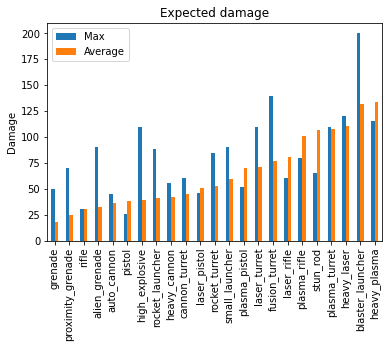

In [6]:
ax = average_damage.plot.bar(title="Expected damage", legend=False)
ax.legend(["Max", "Average"])
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

### Ammo

In [7]:
weapon_ammo = weapon_data[["weapon", "capacity"]]
weapon_ammo = weapon_ammo.rename(columns={"capacity": "ammo"})
weapon_ammo = weapon_ammo.groupby("weapon").max()
weapon_ammo = weapon_ammo.sort_values(by=["ammo"])

# Remove weapons with unlimited ammo
weapon_ammo = weapon_ammo[weapon_ammo["ammo"] < 255]

weapon_ammo

,ammo
weapon,
alien_grenade,1.0
rocket_launcher,1.0
proximity_grenade,1.0
high_explosive,1.0
grenade,1.0
small_launcher,1.0
blaster_launcher,1.0
heavy_cannon,6.0
rocket_turret,8.0


Text(0, 0.5, 'Shots')

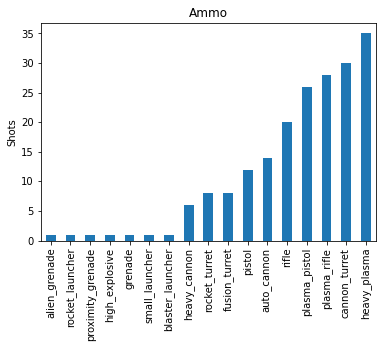

In [8]:
ax = weapon_ammo.plot.bar(title="Ammo", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Shots")

### Damage Per Clip

In [9]:
damage_per_clip = weapon_data[["weapon", "clip_damage"]]
damage_per_clip = damage_per_clip.groupby("weapon").max()
damage_per_clip = damage_per_clip.sort_values(by=["clip_damage"])
damage_per_clip = damage_per_clip.dropna()

# Remove weapons with unlimited ammo
damage_per_clip = damage_per_clip[damage_per_clip["clip_damage"] < 10000]

damage_per_clip

,clip_damage
weapon,
grenade,50.0
proximity_grenade,70.0
alien_grenade,90.0
small_launcher,90.0
rocket_launcher,100.0
high_explosive,110.0
blaster_launcher,200.0
pistol,312.0
heavy_cannon,360.0


Text(0, 0.5, 'Damage')

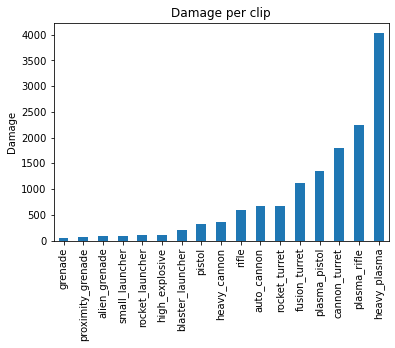

In [10]:
ax = damage_per_clip.plot.bar(title="Damage per clip", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

### Shots Per Turn

Supposing all the attacks are done on auto, or the highest rate of fire setting.

In [11]:
shots_per_turn_max = weapon_data[["weapon", "turn_max_shots"]]
shots_per_turn_max = shots_per_turn_max.groupby("weapon").max()

In [12]:
shots_per_turn_average = weapon_data[["weapon", "turn_max_shots"]]
shots_per_turn_average = shots_per_turn_average.groupby("weapon").mean()

In [13]:
shots_per_turn = shots_per_turn_max.merge(shots_per_turn_average, on="weapon")
shots_per_turn = shots_per_turn.rename(columns={"turn_max_shots_x": "turn_shots_max", "turn_max_shots_y": "turn_shots_avg"})
shots_per_turn = shots_per_turn.sort_values(by=["turn_shots_avg"])
shots_per_turn

,turn_shots_max,turn_shots_avg
weapon,,
alien_grenade,1,1.000000
blaster_launcher,1,1.000000
fusion_turret,1,1.000000
grenade,1,1.000000
rocket_launcher,1,1.000000
high_explosive,1,1.000000
proximity_grenade,1,1.000000
rocket_turret,2,1.500000
small_launcher,2,1.500000


Text(0, 0.5, 'Shots')

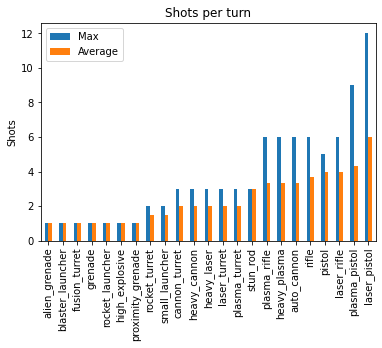

In [14]:
ax = shots_per_turn.plot.bar(title="Shots per turn")
ax.legend(["Max", "Average"])
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Shots")

### Turns of Sustained Fire

In [15]:
turns_sustained_fire_max = weapon_data[["weapon", "turns_to_reload"]]
turns_sustained_fire_max = turns_sustained_fire_max.groupby("weapon").max()

# Remove weapons with unlimited ammo
turns_sustained_fire_max = turns_sustained_fire_max[turns_sustained_fire_max["turns_to_reload"] < 70]

In [16]:
turns_sustained_fire_average = weapon_data[["weapon", "turns_to_reload"]]
turns_sustained_fire_average = turns_sustained_fire_average.groupby("weapon").mean()

# Remove weapons with unlimited ammo
turns_sustained_fire_average = turns_sustained_fire_average[turns_sustained_fire_average["turns_to_reload"] < 70]

In [17]:
turns_sustained_fire = turns_sustained_fire_max.merge(turns_sustained_fire_average, on="weapon")
turns_sustained_fire = turns_sustained_fire.rename(columns={"turns_to_reload_x": "turns_sustained_fire_max", "turns_to_reload_y": "turns_sustained_fire_avg"})
turns_sustained_fire = turns_sustained_fire.sort_values(by=["turns_sustained_fire_max"])
turns_sustained_fire

,turns_sustained_fire_max,turns_sustained_fire_avg
weapon,,
alien_grenade,1.0,1.000000
rocket_launcher,1.0,1.000000
proximity_grenade,1.0,1.000000
grenade,1.0,1.000000
high_explosive,1.0,1.000000
blaster_launcher,1.0,1.000000
small_launcher,1.0,0.750000
pistol,4.0,3.200000
heavy_cannon,6.0,4.000000


Text(0, 0.5, 'Turns')

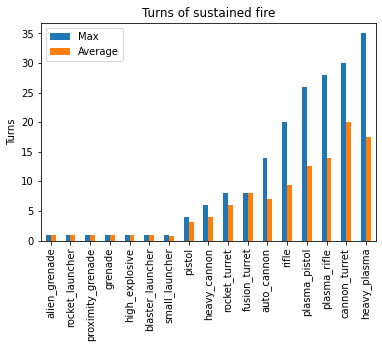

In [18]:
ax = turns_sustained_fire.plot.bar(title="Turns of sustained fire")
ax.legend(["Max", "Average"])
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Turns")